# QuickDraw-like doodle recognition !
You can check the game below: <br />
https://quickdraw.withgoogle.com/

Import all the usefull libraries<br />
- `tensorflow` :    machine learning model
- `numpy` :         data shaping
- `mathplotlib` :   visualize the data
- `os` :            read your directories / files
- `urllib` :        retrieve urls

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request

### Dowload the QuickDraw datasets <br />
You can see their datasets here: <br />
https://quickdraw.withgoogle.com/data <br /><br />

Here we just download the simplified numpy_bitmaps from the QuickDraw! datasets.<br />
We get the data from here:<br />https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?prefix=&forceOnObjectsSortingFiltering=false <br />
We simply download the datasets for each classe that appears in the "mini_classes.txt" file.<br />
Already existing data will not be replaced.

In [14]:
os.system('cls' if os.name == 'nt' else 'clear')
class_names = []

if (not os.path.exists("data")):
    os.mkdir("data")
f= open("mini_classes.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
ind = 0
for c in classes:
    c_url = c.replace('_', '%20')
    print("Downloading " + c + " - [" + str(ind) + " /" + str(len(classes)) + "]")
    full_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/" + c_url + ".npy"
    if (not os.path.exists('data/' + c + ".npy")):
        urllib.request.urlretrieve(full_url, 'data/' + c + ".npy")
    ind += 1
print("Downloaded " + "[" + str(ind) + " /" + str(len(classes)) + "]")

Downloaded [10 /10]


### Process the Data

In [15]:
all_files = ['data/' + s for s in os.listdir("data")]
x_data = np.empty([0, 784]) ## 28x28
y_labels = np.empty([0])

vfold_ratio=0.2 ## 20% of data for validation
max_items_per_class=4000 ## 4000 items per class

## Load data
for idx, file in enumerate(all_files):
    data = np.load(file)
    data = data[0:max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x_data = np.concatenate((x_data, data), axis=0)
    y_labels = np.append(y_labels, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

data = None
labels = None

## Shuffle data
permutation = np.random.permutation(y_labels.shape[0])

x_data = x_data[permutation, :]
y_labels = y_labels[permutation]

## Split data validation from test data
vfold_size = int(x_data.shape[0]/100*(vfold_ratio*100))

x_test = x_data[0:vfold_size, :]
y_test = y_labels[0:vfold_size]

x_train = x_data[vfold_size:x_data.shape[0], :]
y_train = y_labels[vfold_size:x_data.shape[0]]

num_classes = len(os.listdir("data"))
image_size = 28

### Get an overview of the data

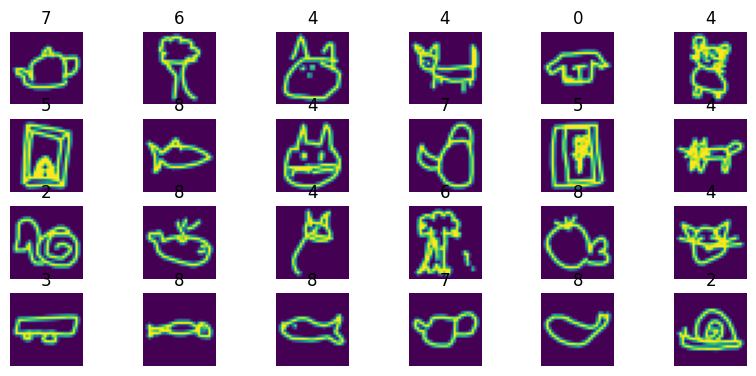

In [4]:
plt.figure(figsize=(10, 10))

for i in range(24):
    ax = plt.subplot(9, 6, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.title(int(y_train[i]))
    plt.axis("off")
plt.show()

### Shape the data to match the model format

In [16]:
## Reshape data to fit model
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

## Normalize pixel values to be between 0 and 1
x_train /= 255.0
x_test /= 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

32000 train samples
8000 test samples


### Create your model
Keras layers: <br />
https://www.tensorflow.org/api_docs/python/tf/keras/layers <br /> <br />

You might use Convoltion2D and MaxPooling2D layers. <br />
You can try other layers type if you wish to. <br /> <br />
Internet is also full of common architectures exemples for different kind of models. <br />
(ex: https://www.jeremyjordan.me/convnet-architectures/ <br /> https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/) <br /> <br />
You need to complete your model with a "Flatten" and two "Dense" layers to match the output shape. <br />
Flatten without specifing any arguments. <br />
Dense with a specified number of nodes and an activation function. <br />
Dense with the number of classes to recognise as the node number and 'softmax' as the activation function. <br /> <br />

Your model has already been defined with `model = keras.Sequential()`. <br />
To add a layer to your model, just use the add method (`model.add()`) <br />
The different layer classes can be accessed through `tensorflow.keras.layers` but we imported it directly as `layers`,<br />
so just type  (`layers.`layer_name).

In [5]:
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # 32 filters, 5x5 kernel
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='sigmoid')) # 64 filters, 3x3 kernel
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(os.listdir("data")), activation='softmax'))

2023-02-08 18:18:49.961416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile and Train your model
The loss function specified is `categorical_crossentropy`, which is used for multiclass classification problems and measures the dissimilarity between the predicted probability distribution and the true distribution.

The optimizer specified is `adam`, which is an optimization algorithm commonly used for deep learning.

The metrics specified is `top_k_categorical_accuracy`, which is used to measure the accuracy of the model for the top k predictions where k is a user-defined number. It's used to evaluate the model's performance.

In [6]:
## Compile model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
            optimizer=adam,
            metrics=['top_k_categorical_accuracy'])

## Train model
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=3)
model.save('dr.h5')
model.save_weights('drWeight.h5')

Epoch 1/3
113/113 - 6s - loss: 1.5435 - top_k_categorical_accuracy: 0.8370 - val_loss: 0.8203 - val_top_k_categorical_accuracy: 0.9784 - 6s/epoch - 50ms/step
Epoch 2/3
113/113 - 5s - loss: 0.6918 - top_k_categorical_accuracy: 0.9772 - val_loss: 0.5797 - val_top_k_categorical_accuracy: 0.9812 - 5s/epoch - 43ms/step
Epoch 3/3
113/113 - 5s - loss: 0.5576 - top_k_categorical_accuracy: 0.9810 - val_loss: 0.4821 - val_top_k_categorical_accuracy: 0.9819 - 5s/epoch - 47ms/step


Your model has now been trained and generated a `dr.h5` and `drWeight.h5` files, these corresponds to your trained model and its reprocessed weights. <br /> You can now load the model to feed it the image you want to recognize.

Launch the paint program ( `./paint` in your terminal ) to test your ai.